# FEniCS101 Tutorial

In this tutorial we consider the boundary value problem (BVP)

\begin{eqnarray*}
- \nabla \cdot (k \nabla u) = f &      \text{ in } \Omega,\\
u = u_0 & \text{ on } \Gamma_D = \Gamma_{\rm left} \cup \Gamma_{\rm right},\\
k \frac{\partial u}{\partial {\bf{n}}} = \sigma & \text{ on } \Gamma_N = \Gamma_{\rm top} \cup \Gamma_{\rm bottom},
\end{eqnarray*}

where $\Omega = (0,1) \times (0,1)$, $\Gamma_D$ and $\Gamma_N$ are the union of
the left and right, and top and bottom boundaries of $\Omega$,
respectively.

Here
\begin{eqnarray*}
k(x,y) = 1  & \text{ on } \Omega\\
f(x,y) = \left(4\pi^2+\frac{\pi^2}{4}\right)\sin(2 \pi x) \sin\left(\frac{\pi}{2} y\right) & \text{ on } \Omega\\
u_0(x,y)      = 0 & \text{ on } \Gamma_D, \\
\sigma(x) = \left\{ \begin{array}{l} -\frac{\pi}{2}\sin(2 \pi x) \\ 0 \end{array}\right.
& \begin{array}{l} \text{ on } \Gamma_{\rm bottom},\\ \text{ on } \Gamma_{\rm top}.\end{array}
\end{eqnarray*}

The exact solution is
$$ u_e(x,y) = \sin(2\pi x)\sin\left(\frac{\pi}{2}y\right). $$

## Weak formulation

Let us define the Hilbert spaces $V_{u_0}, V_0 \in \Omega$ as
$$ V_{u_0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = u_0 \text{ on } \Gamma_D \right\},$$
$$ V_{0} := \left\{ v \in H^1(\Omega) \text{ s. t. } v = 0 \text{ on } \Gamma_D \right\}.$$

To obtain the weak formulation, we multiply the PDE by an arbitrary function $v \in V_0$ and integrate over the domain $\Omega$ leading to

$$ -\int_{\Omega} \nabla \cdot (k \nabla u) v \, dx = \int_\Omega f v \, dx\quad \forall \; v \in V_0. $$

Then, integration by parts the non-conforming term gives

$$ \int_{\Omega} k \nabla u \cdot \nabla v \, dx - \int_{\partial \Omega} k \frac{\partial u}{\partial {\bf n} } v \, ds = \int_\Omega f v \, dx \quad \forall \; v \in V_0. $$

Finally by recalling that $ v = 0 $ on $\Gamma_D$ and that $k \frac{\partial u}{\partial {\bf n} } = \sigma $ on $\Gamma_N$, we find the weak formulation:

*Find * $u \in V_{u_0}$ *such that*
$$ \int_{\Omega} k \nabla u \cdot \nabla v \, dx = \int_\Omega f v \, dx + \int_{\Gamma_N} \sigma v \, ds \quad \forall \; v \in V_0. $$

## 1. Load modules

To start we load the following modules:

- dolfin: the python/C++ interface to FEniCS

- [math](https://docs.python.org/2/library/math.html): the python module for mathematical functions

- [numpy](http://www.numpy.org/): a python package for linear algebra

- [matplotlib](http://matplotlib.org/): a python package used for plotting the results

In [1]:
from __future__ import absolute_import, division, print_function

from dolfin import *

import math
import numpy as np
import logging

import matplotlib.pyplot as plt
%matplotlib inline

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import nb

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
set_log_active(False)

--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---
--- Instant: compiling ---


## 2. Define the mesh and the finite element space

We construct a triangulation (mesh) $\mathcal{T}_h$ of the computational domain $\Omega := [0, 1]^2$ with `n` elements in each direction.

On the mesh $\mathcal{T}_h$, we then define the finite element space $V_h \subset H^1(\Omega)$ consisting of globally continuous piecewise polynomials. The `degree` variable defines the polynomial degree.

dim(Vh) =  289


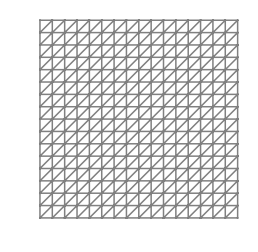

In [2]:
n = 16
degree = 1
mesh = UnitSquareMesh(n, n)
nb.plot(mesh)

Vh  = FunctionSpace(mesh, 'Lagrange', degree)
print( "dim(Vh) = ", Vh.dim() )

## 3. Define boundary labels

To partition the boundary of $\Omega$ in the subdomains $\Gamma_{\rm top}$, $\Gamma_{\rm bottom}$, $\Gamma_{\rm left}$, $\Gamma_{\rm right}$ we assign a unique label `boundary_parts` to each of part of $\partial \Omega$.

In [3]:
class TopBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1] - 1) < DOLFIN_EPS
    
class BottomBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[1]) < DOLFIN_EPS
    
class LeftBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0]) < DOLFIN_EPS
    
class RightBoundary(SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and abs(x[0] - 1) < DOLFIN_EPS
    
boundary_parts = FacetFunction("size_t", mesh)
boundary_parts.set_all(0)

Gamma_top = TopBoundary()
Gamma_top.mark(boundary_parts, 1)
Gamma_bottom = BottomBoundary()
Gamma_bottom.mark(boundary_parts, 2)
Gamma_left = LeftBoundary()
Gamma_left.mark(boundary_parts, 3)
Gamma_right = RightBoundary()
Gamma_right.mark(boundary_parts, 4)

## 4. Define the coefficients of the PDE and the boundary conditions

We first define the coefficients of the PDE using the `Constant` and `Expression` classes. `Constant` is used to define coefficients that do not depend on the space coordinates, `Expression` is used to define coefficients that are a known function of the space coordinates `x[0]` (x-axis direction) and `x[1]` (y-axis direction).

In the finite element method community, Dirichlet boundary conditions are also known as *essential* boundary conditions since they are imposed directly in the definition of the finite element space. In FEniCS, we use the class `DirichletBC` to indicate this type of condition.

On the other hand, Newman boundary conditions are also known as *natural* boundary conditions since they are weakly imposed as boundary integrals in the variational formulation (weak form). In FEniCS, we create a new boundary measure `ds[i]` to integrate over the portion of the boundary marked with label `i`.

In [4]:
u_L = Constant(0.)
u_R = Constant(0.)

sigma_bottom = Expression('-(pi/2.0)*sin(2*pi*x[0])', degree=5)
sigma_top    = Constant(0.)

f = Expression('(4.0*pi*pi+pi*pi/4.0)*(sin(2*pi*x[0])*sin((pi/2.0)*x[1]))', degree=5)

bcs = [DirichletBC(Vh, u_L, boundary_parts, 3),
       DirichletBC(Vh, u_R, boundary_parts, 4)]

ds = Measure("ds", subdomain_data=boundary_parts)

--- Instant: compiling ---
--- Instant: compiling ---


## 5. Define and solve the variational problem

We also define two special types of functions: the `TrialFunction` `u` and the `TestFunction` `v`. These special types of function are used by `FEniCS` to generate the finite element vectors and matrices which stem from the weak formulation of the PDE.

More specifically, by denoting by $\left[{\phi_i(x)}\right]_{i=1}^{{\rm dim}(V_h)}$ the finite element basis for the space $V_h$, a function $u_h \in V_h$ can be written as
$$ u_h = \sum_{i=1}^{{\rm dim}(V_h)} {\rm u}_i \phi_i(x), $$
where ${\rm u}_i$ represents the coefficients in the finite element expansion of $u_h$.

We then define

- the bilinear form $a(u_h, v_h) = \int_\Omega \nabla u_h \cdot \nabla v_h \, dx $;

- the linear form $L(v_h) = \int_\Omega f v_h \, dx + \int_{\Gamma_{\rm top}} \sigma_{\rm top} v_h \, ds + \int_{\Gamma_{\rm bottom}} \sigma_{\rm bottom} v_h \,ds $.


We can then solve the variational problem

*Find *$u_h \in V_h$* such that*
$$ a(u_h, v_h) = L(v_h) \quad \forall\, v_h \in V_h $$

using directly the built-in `solve` method in FEniCS.

**NOTE:** As an alternative one can also assemble the finite element matrix $A$ and the right hand side $b$ that stems from the discretization of $a$ and $L$, and then solve the linear system
$$ A {\rm u} = {\rm b}, $$
where

- ${\rm u}$ is the vector collecting the coefficients of the finite element expasion of $u_h$,

- the entries of the matrix A are such that $A_{ij} = a(\phi_j, \phi_i)$,

- the entries of the right hand side b are such that $b_i = L(\phi_i)$.

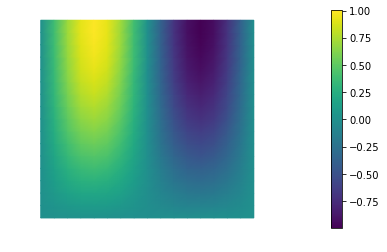

In [5]:
u = TrialFunction(Vh)
v = TestFunction(Vh)
a = inner(nabla_grad(u), nabla_grad(v))*dx
L = f*v*dx + sigma_top*v*ds(1) + sigma_bottom*v*ds(2)

uh = Function(Vh)

#solve(a == L, uh, bcs=bcs)
A, b = assemble_system(a,L, bcs=bcs)
solve(A, uh.vector(), b, "cg")

nb.plot(uh)

## 6. Compute the discretization error

For this problem, the exact solution is known.
We can therefore compute the following norms of the discretization error (i.e. the difference between the finite element solution $u_h$ and the exact solution $u_{\rm ex}$)
$$ \| u_{\rm ex} - u_h \|_{L^2{\Omega}} := \sqrt{ \int_{\Omega} (u_{\rm ex} - u_h)^2 \, dx }, $$ 
and
$$ \| u_{\rm ex} - u_h \|_{H^1{\Omega}} := \sqrt{ \int_{\Omega} (u_{\rm ex} - u_h)^2 \, dx + \int_{\Omega} |\nabla u_{\rm ex} - \nabla u_h|^2 \, dx}. $$

In [6]:
u_e = Expression('sin(2*pi*x[0])*sin((pi/2.0)*x[1])', degree=5)
grad_u_e = Expression( ('2*pi*cos(2*pi*x[0])*sin((pi/2.0)*x[1])', 'pi/2.0*sin(2*pi*x[0])*cos((pi/2.0)*x[1])'), degree=5)

err_L2 = sqrt( assemble( (uh-u_e)**2*dx ) )
err_grad = sqrt( assemble( inner(nabla_grad(uh) - grad_u_e, nabla_grad(uh) - grad_u_e)*dx ) )
err_H1 = sqrt( err_L2**2 + err_grad**2)

print ("|| u_h - u_e ||_L2 = ", err_L2)
print ("|| u_h - u_e ||_H1 = ", err_H1)

--- Instant: compiling ---
--- Instant: compiling ---


|| u_h - u_e ||_L2 =  0.00880525372208
|| u_h - u_e ||_H1 =  0.396718952514


## 7. Convergence of the finite element method

We now verify numerically a well-known convergence result for the finite element method.

Let $s$ denote the polynomial degree of the finite element space, and assume that the solution $u_{\rm ex}$ is at least in $H^{s+1}(\Omega)$. Then we have
$$ \| u_{\rm ex} - u_h \|_{H^1} \leq C h^{s}, \quad \| u_{\rm ex} - u_h \|_{L^2} \leq C h^{s+1}. $$

In the code below, the function `compute(n, degree)` solves the PDE using a mesh with `n` elements in each direction and finite element spaces of polynomial order `degree`.

The figure below shows the discretization errors in the $H^1$ and $L^2$ as a function of the mesh size $h$ ($h = \frac{1}{n}$) for piecewise linear (P1, $s=1$) and piecewise quadratic (P2, $s=2$) finite elements. We observe that numerical results are consistent with the finite element convergence theory. In particular:

- for piecewise linear finite element P1 we observe first order convergence in the $H^1$-norm and second order convergence in the $L^2$-norm;

- for piecewise quadratic finite element P2 we observe second order convergence in the $H^1$-norm and third order convergence in the $L^2$-norm.

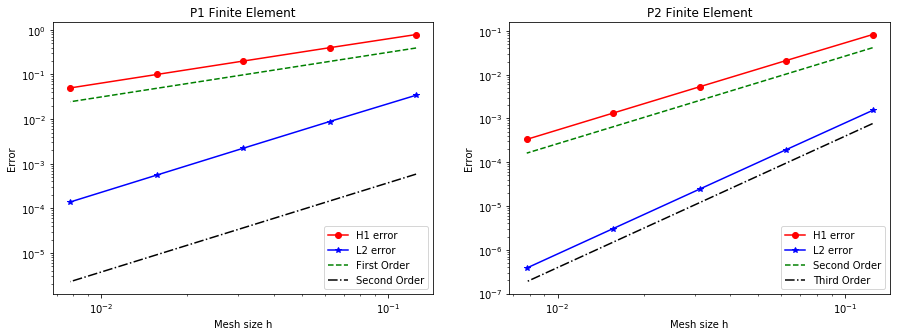

In [7]:
def compute(n, degree):
    mesh = UnitSquareMesh(n, n)
    Vh  = FunctionSpace(mesh, 'Lagrange', degree)
    boundary_parts = FacetFunction("size_t", mesh)
    boundary_parts.set_all(0)
    
    Gamma_top = TopBoundary()
    Gamma_top.mark(boundary_parts, 1)
    Gamma_bottom = BottomBoundary()
    Gamma_bottom.mark(boundary_parts, 2)
    Gamma_left = LeftBoundary()
    Gamma_left.mark(boundary_parts, 3)
    Gamma_right = RightBoundary()
    Gamma_right.mark(boundary_parts, 4)
    
    bcs = [DirichletBC(Vh, u_L, boundary_parts, 3), DirichletBC(Vh, u_R, boundary_parts, 4)]
    ds = Measure("ds", subdomain_data=boundary_parts)
    
    u = TrialFunction(Vh)
    v = TestFunction(Vh)
    a = inner(nabla_grad(u), nabla_grad(v))*dx
    L = f*v*dx + sigma_top*v*ds(1) + sigma_bottom*v*ds(2)
    uh = Function(Vh)
    solve(a == L, uh, bcs=bcs)
    err_L2 = sqrt( assemble( (uh-u_e)**2*dx ) )
    err_grad = sqrt( assemble( inner(nabla_grad(uh) - grad_u_e, nabla_grad(uh) - grad_u_e)*dx ) )
    err_H1 = sqrt( err_L2**2 + err_grad**2)
    
    return err_L2, err_H1

nref = 5
n = 8*np.power(2,np.arange(0,nref))
h = 1./n

err_L2_P1 = np.zeros(nref)
err_H1_P1 = np.zeros(nref)
err_L2_P2 = np.zeros(nref)
err_H1_P2 = np.zeros(nref)

for i in range(nref):
    err_L2_P1[i], err_H1_P1[i] = compute(n[i], 1)
    err_L2_P2[i], err_H1_P2[i] = compute(n[i], 2)
    
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.loglog(h, err_H1_P1, '-or', label = "H1 error")
plt.loglog(h, err_L2_P1, '-*b', label = "L2 error")
plt.loglog(h, h*.5*err_H1_P1[0]/h[0], '--g', label = "First Order")
plt.loglog(h, np.power(h,2)*.5*np.power( err_L2_P1[0]/h[0], 2), '-.k', label = "Second Order")
plt.xlabel("Mesh size h")
plt.ylabel("Error")
plt.title("P1 Finite Element")
plt.legend(loc='lower right')


plt.subplot(122)
plt.loglog(h, err_H1_P2, '-or', label = "H1 error")
plt.loglog(h, err_L2_P2, '-*b', label = "L2 error")
plt.loglog(h, np.power(h/h[0],2)*.5*err_H1_P2[0], '--g', label = "Second Order")
plt.loglog(h, np.power(h/h[0],3)*.5*err_L2_P2[0], '-.k', label = "Third Order")
plt.xlabel("Mesh size h")
plt.ylabel("Error")
plt.title("P2 Finite Element")
plt.legend(loc='lower right')

plt.show()

Copyright (c) 2016-2018, The University of Texas at Austin & University of California, Merced.<br>
All Rights reserved.<br>
See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code
availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.